# Lesson 04: Classification Performance ROCs

- evaluating and comparing trained models is of extreme importance when deciding in favor/against
  + model architectures
  + hyperparameter sets
  
- evaluating performance or quality of prediction is performed with a myriad of tests, figure-of-merits and even statistical hypothesis testing
- in the following, the rather popular "Receiver Operating Characteristic" curve (spoken ROC curve)
- the ROC was invented in WWII by radar engineers when seeking to detect enemy vessels and comparing different devices/techniques


## preface
- two main ingredients to ROC:

    + TPR = True Positive Rate
    + FPR = False Positive Rate
    

![from Wikipedia, ROC article](https://raw.githubusercontent.com/deeplearning540/lesson04/main/images/Screenshot_2021-02-24-Wikipedia-ROC.png)

- $TPR = \frac{TP}{TP+FN}$ also known as `recall`, always within $[0,1]$
- $FPR = \frac{FP}{FP+TN}$ also known as `fall-out`, always within $[0,1]$

## Data

For the following, I will rely (again) on the Palmer penguin dataset obtained from [this repo](https://github.com/allisonhorst/palmerpenguins). To quote the repo:

> Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
> and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/).


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
#let's remove the rows with NaN values
df = df[ df.bill_length_mm.notnull() ]
#convert species column to 
df[["species_"]] = df[["species"]].astype("category")


In [3]:
print(df.shape)
print((df.species_.cat.codes < 1).shape)

#create binary column
df["is_adelie"] = (df.species_.cat.codes < 1).astype(np.int8)

print(df.head())


(342, 9)
(342,)
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year species_  is_adelie  
0       3750.0    male  2007   Adelie          1  
1       3800.0  female  2007   Adelie          1  
2       3250.0  female  2007   Adelie          1  
4       3450.0  female  2007   Adelie          1  
5       3650.0    male  2007   Adelie          1  


In [4]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
print(f'seaborn version: {sns.__version__}')

seaborn version: 0.11.2


In [5]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split

kmeans = knn(n_neighbors=5)

In [6]:
#this time we train the knn algorithm, i.e. an unsupervised method is used in a supervised fashion
#prepare the data
X = np.stack((df.bill_length_mm, df.flipper_length_mm), axis=-1)
y = df.is_adelie

print(X.shape)
print(y.shape)


(342, 2)
(342,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .15,
                                                    random_state = 20220427)

print(X_train.shape)
print(y_train.shape)


print(X_test.shape)
print(y_test.shape)



(290, 2)
(290,)
(52, 2)
(52,)


In [8]:
kmeans = kmeans.fit(X_train, y_train)


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_hat = kmeans.predict(X_test)

cm = confusion_matrix( y_test, y_test_hat )

print(cm)


[[28  1]
 [ 1 22]]


1


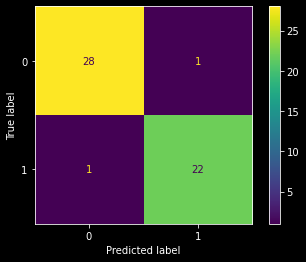

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(int(True))

### Starting to ROC

Let's take 4 samples of different size from our test set

In [14]:
n_exp = 4

X_test_exp = np.split(X_test[:32,...], n_exp, axis=0)

In [17]:
y_test_exp = np.split(y_test.values[:32,...], n_exp, axis=0)

print(X_test_exp[0].shape)
print(y_test_exp[0].shape)

(8, 2)
(8,)


In [18]:
y_test_hat = kmeans.predict(X_test)

y_test_hat_exp = np.split(y_test_hat[:32,...], n_exp, axis=0)

In [23]:
from sklearn.metrics import recall_score as tpr

def fpr(y_true, y_pred):
  """ calculate false positive rate using confusion matrix for binary classification"""
  cm = confusion_matrix(y_true, y_pred)
  assert cm.shape == (2,2)
  cond_pos = c[:,1].sum()
  fpr= cm[0,1]/cond_pos
  return fpr


fpr_=[]
tpr_=[]

for i in range(len(y_test_exp)):

  fpr_.append( fpr(y_test_exp[i], y_test_hat_exp[i]) )

  tpr_.append( tpr(y_test_exp[i], y_test_hat_exp[i]) )

print(fpr_)
print(tpr_)

[0.0, 0.14285714285714285, 0.0, 0.0]
[1.0, 1.0, 1.0, 0.75]


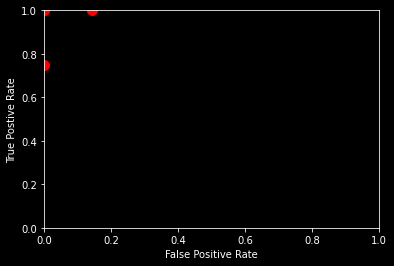

In [24]:
f,ax = plt.subplots(1)

ax.plot(fpr_, tpr_, "ro", markersize=10)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Postive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

# Further Reading

- some parts of this material were inspired by [Sebastian Raschka](https://sebastianraschka.com)
  + [lecture 12.4, Receiver Operating Curve](https://youtu.be/GdSEkiArM3k)
  
- a generally good resource 
  + [Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
  
- all of the above is nicely implemented and documented 
  + [sklearn examples](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
  + [roc_curve API docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)

- [extensive discussion of ROC](https://stackabuse.com/understanding-roc-curves-with-python/)
  

In [35]:
from sklearn.metrics import roc_curve
probas = kmeans.predict_proba(X_test)
pos_pred = probas[:,-1]

fpr, tpr, thr = roc_curve(y_test, pos_pred)

print("false postive rate :", fpr)
print("True positive rate :", tpr)
print("Decision Tresholds :", thr)


false postive rate : [0.         0.03448276 0.06896552 0.24137931 1.        ]
True positive rate : [0.         0.95652174 0.95652174 0.95652174 1.        ]
Decision Tresholds : [2.  1.  0.4 0.2 0. ]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


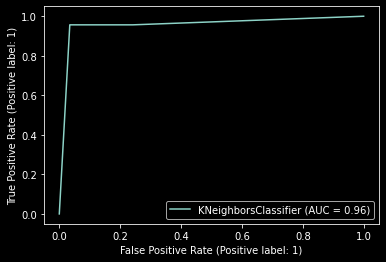

In [36]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(kmeans, X_test, y_test)

<h1><a href="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/220px-Roc_curve.svg.png"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/220px-Roc_curve.svg.png"/></a>
</h1>


*   nearest neigbor clustering algorithm are able to offer a probabilistic score for each predicted outcome based on the neigborhood chosen
*   the ROC is an envelope that describes how well a classifier perfomrs given a fixed testset

ROC expresses the blance between true postives and false postives



